In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from utils.streams import Dataset

%matplotlib inline
#%matplotlib qt

plt.style.use('ggplot')


In [9]:
stream_root_folder = r"C:\Users\neurogears\Desktop\EC_datasets\EmpaticaLDRBenchmark2022_09_26_18_06_45"
dataset = Dataset(stream_root_folder)
dataset.populate_streams(autoload = False)

In [10]:
#Load necessary streams for the test
dataset.streams.Empatica.load()
dataset.streams.BioData.ECG.load()


In [11]:
#Manually construct a new stream
from utils.streams import HarpStream
dataset.streams.BioData.Photodiode = HarpStream(-1, device = 'BioData', streamlabel = 'Photodiode', root = '', autoload = False)
dataset.streams.BioData.Photodiode.data = dataset.streams.BioData.ECG.data.loc[:,"Value1"]


In [12]:
dataset.streams.Empatica.data.E4_Tag


,Stream,E4_Seconds,Value
Seconds,,,
1904-01-01 01:43:20.285984,E4_Tag,1956-09-25 17:06:54.166069984,1.251647e+09
1904-01-01 01:43:32.390976,E4_Tag,1956-09-25 17:07:06.197880030,1.252044e+09
1904-01-01 01:43:47.285984,E4_Tag,1956-09-25 17:07:21.151700020,1.252533e+09
1904-01-01 01:43:53.293984,E4_Tag,1956-09-25 17:07:27.167599916,1.252731e+09
1904-01-01 01:44:04.252000,E4_Tag,1956-09-25 17:07:37.996229887,1.253089e+09
...,...,...,...
1904-01-01 02:00:01.344992,E4_Tag,1956-09-25 17:23:35.212430000,1.269026e+09
1904-01-01 02:00:07.261984,E4_Tag,1956-09-25 17:23:41.228339911,1.269075e+09
1904-01-01 02:00:12.370976,E4_Tag,1956-09-25 17:23:46.384829998,1.269117e+09


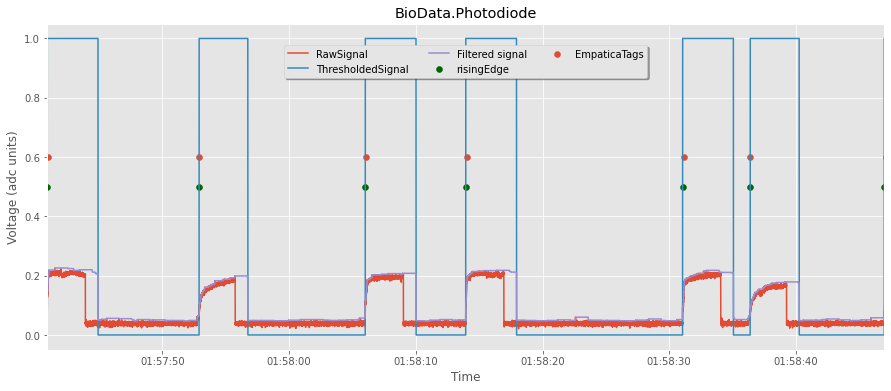

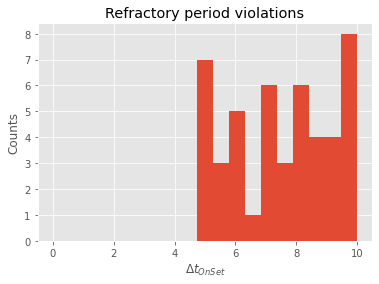

In [13]:
rolling_max = dataset.streams.BioData.Photodiode.data.rolling('1s').max() #get rid of double hits due to hysteresis using a max-window filter.

thr = 70
ttl = (rolling_max > thr).astype(int)
pd_rising_edge = ttl[np.where(np.diff(ttl) == 1)[0]]

fig = plt.figure(figsize= (15,6))
plt.title(dataset.streams.BioData.Photodiode.device + "." + dataset.streams.BioData.Photodiode.streamlabel)
plt.plot(dataset.streams.BioData.Photodiode.data/1000, label = 'RawSignal')
plt.plot(ttl, label = 'ThresholdedSignal')
plt.scatter(x = pd_rising_edge.index, y = pd_rising_edge.values*0 + 0.5, color = "darkgreen", label = 'risingEdge')
plt.plot(rolling_max/1000, label = 'Filtered signal')
plt.ylabel('Voltage (adc units)')
plt.xlabel('Time')
plt.scatter(dataset.streams.Empatica.data.E4_Tag.index,  np.ones((len(dataset.streams.Empatica.data.E4_Tag.index),1)) * 0.6, label = "EmpaticaTags")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95),
          ncol=3, fancybox=True, shadow=True)


plt.xlim((pd_rising_edge.index[82], pd_rising_edge.index[88]))
plt.show()

#Confirm no double hits were detected:
plt.figure()
plt.hist(np.diff(pd_rising_edge.index.values)/ np.timedelta64(1, 's'), np.linspace(0, 10, 20))
plt.xlabel('$\Delta t_{OnSet}$')
plt.ylabel('Counts')
plt.title('Refractory period violations')
plt.show()


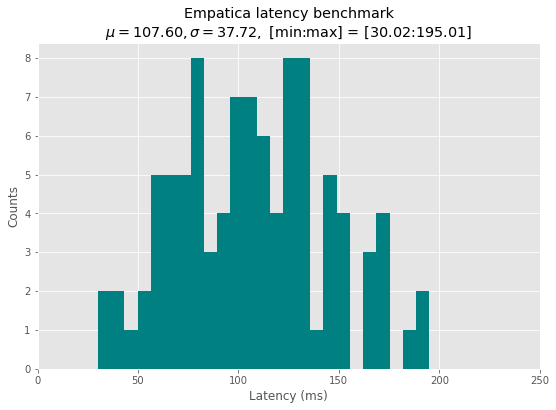

In [17]:
delta_t = pd_rising_edge.index.values - dataset.streams.Empatica.data.E4_Tag.index.values
delta_t = -delta_t / np.timedelta64(1, 'ms')
delta_t = delta_t[delta_t > 0]

plt.figure(figsize= (9,6))
plt.hist(delta_t, bins = 25, color= "Teal")
plt.xlabel('Latency (ms)')
plt.ylabel('Counts')
plt.xlim((0,250))
plt.title(f'Empatica latency benchmark\n$\mu = {np.mean(delta_t):.2f}, \sigma = {np.std(delta_t):.2f},$ [min:max] = [{np.min(delta_t):.2f}:{np.max(delta_t):.2f}]')
plt.show()